# dataset that plays nice with pytorch dataloader (fancy/efficient iterator)

In [1]:
import os, json
from collections import Iterable

import numpy as np
import pandas as pd
from PIL import Image
from IPython.core.display import display

import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

from torch.utils.data.dataloader import default_collate as collate

In [2]:
def torch_to_PIL_single_image(x):
    x = x.numpy().transpose(2,1,0)
    for i,c in enumerate(tuple('RGB')):
        x[:,:,i] -= np.min(x[:,:,i])
        if np.max(x[:,:,i]) > 0:
            x[:,:,i] /= np.max(x[:,:,i])/255
    return Image.fromarray(x.astype(np.uint8))

In [3]:
def load_greyscale(img_path, *args, **kwargs):
    with open(img_path, 'rb') as f:
        img = Image.open(f)
        return img.convert('L')

In [4]:
class dataframeDatasetHPA(Dataset):
    """dataframe Dataset class for HPA data."""

    def __init__(self, df,
                 root_dir='images',
                 image_cols=('microtubuleChannel', 'antibodyChannel', 'nuclearChannel'),
                 image_transform=transforms.Compose([transforms.ToTensor()]),
                 metadata_cols={'EnsemblID','proteinID','antibodyName','antigenSequence'}):
        """
        Args:
            df (pandas.DataFrame): dataframe containing the image locations (relative to root_dir) and metadata
            root_dir (string): full path to the directory containing all the images
            image_cols (tuple of strings): column names in dataframe containing the paths to the single channel
            image_transform (callable): torchvision transform to be applied on a sample
            metadata_cols (tuple of strings): columns whose entries will be returned for each data point
        """
        self.opts = locals()
        self.opts.pop('self')
        self.opts.pop('df')

        self.df = df.reset_index(drop=True)
        self._image_transform = self.opts['image_transform']

    def __len__(self):
        return len(self.df)

    def _get_item(self, idx):
        image_paths = [os.path.join(self.opts['root_dir'], self.df[col][idx]) for col in self.opts['image_cols']]
        image = torch.stack([self._image_transform(load_greyscale(image_path)).squeeze() for image_path in image_paths])
        metadata = {md_col:self.df[md_col][idx] for md_col in self.opts['metadata_cols']}
        return {'image':image, **metadata}

    def __getitem__(self, idx):
        return collate([self._get_item(i) for i in idx]) if isinstance(idx,Iterable) else self._get_item(idx)

In [5]:
df = pd.read_csv('test.csv')
dset = dataframeDatasetHPA(df, root_dir='test_images',
                           image_cols=('microtubuleChannel', 'antibodyChannel', 'nuclearChannel'),
                           image_transform=transforms.Compose([transforms.Resize(1024),
                                                               transforms.ToTensor(),
                                                               transforms.Normalize([0.485, 0.456, 0.406],
                                                                                    [0.229, 0.224, 0.225])]),
                           metadata_cols=('EnsemblID','proteinID','antibodyName','antigenSequence'))

In [6]:
dloader = DataLoader(dset, **{'batch_size':4, 'shuffle':True, 'drop_last':True, 'num_workers':4, 'pin_memory':True})

In [7]:
i,minibatch = next(enumerate(dloader))

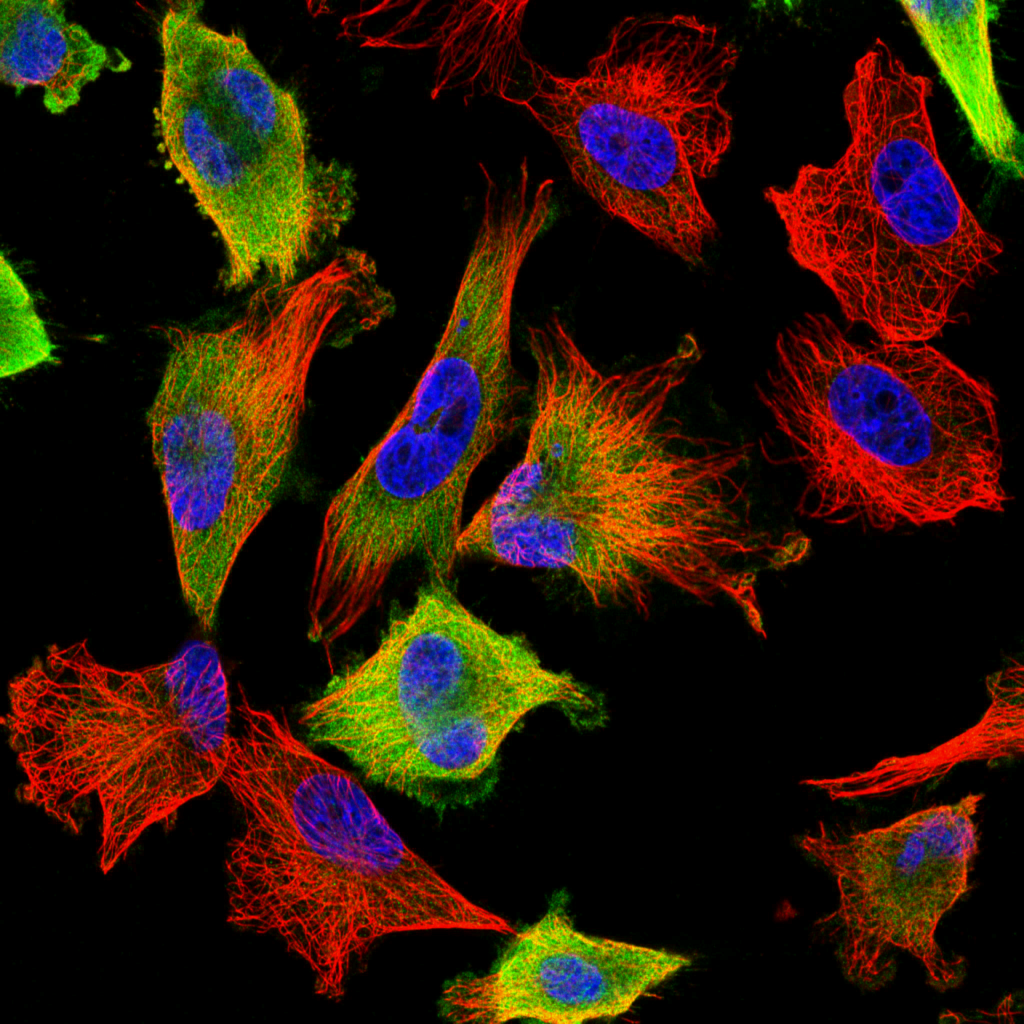

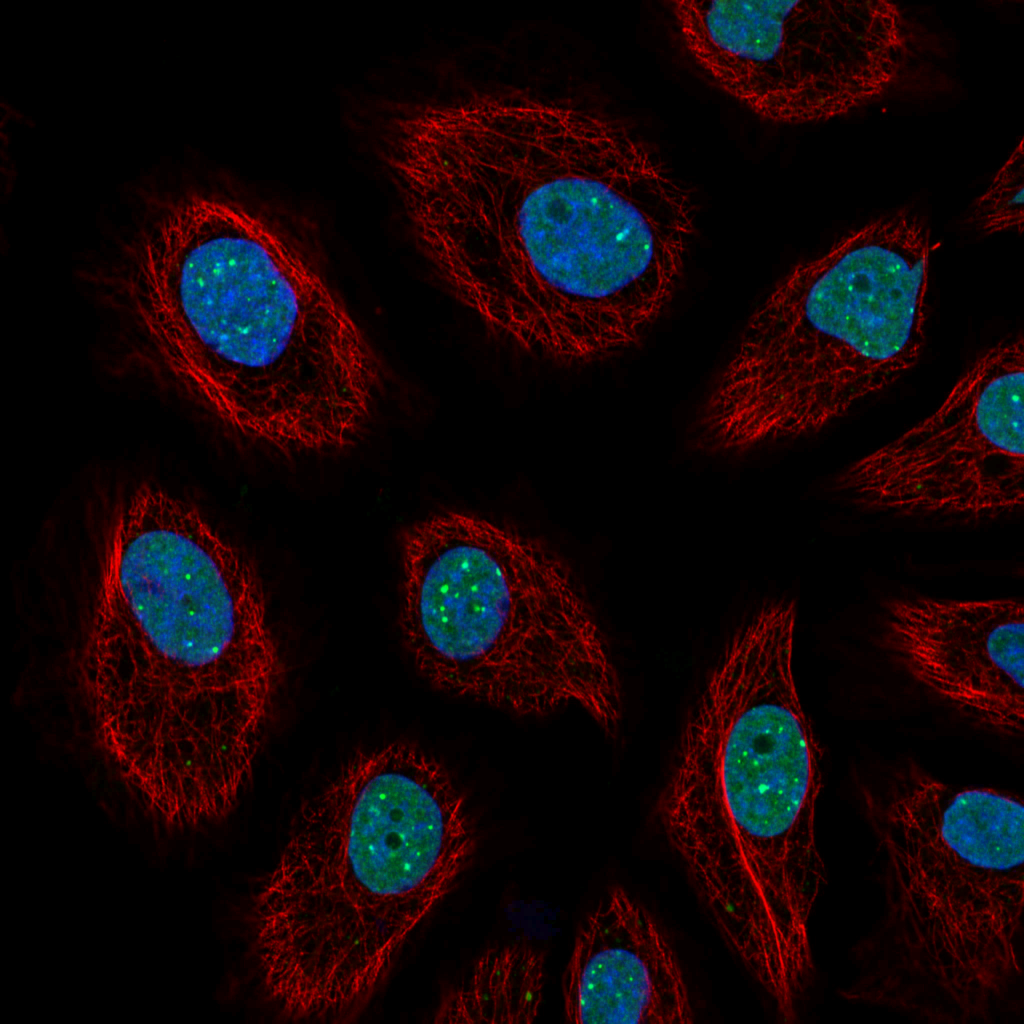

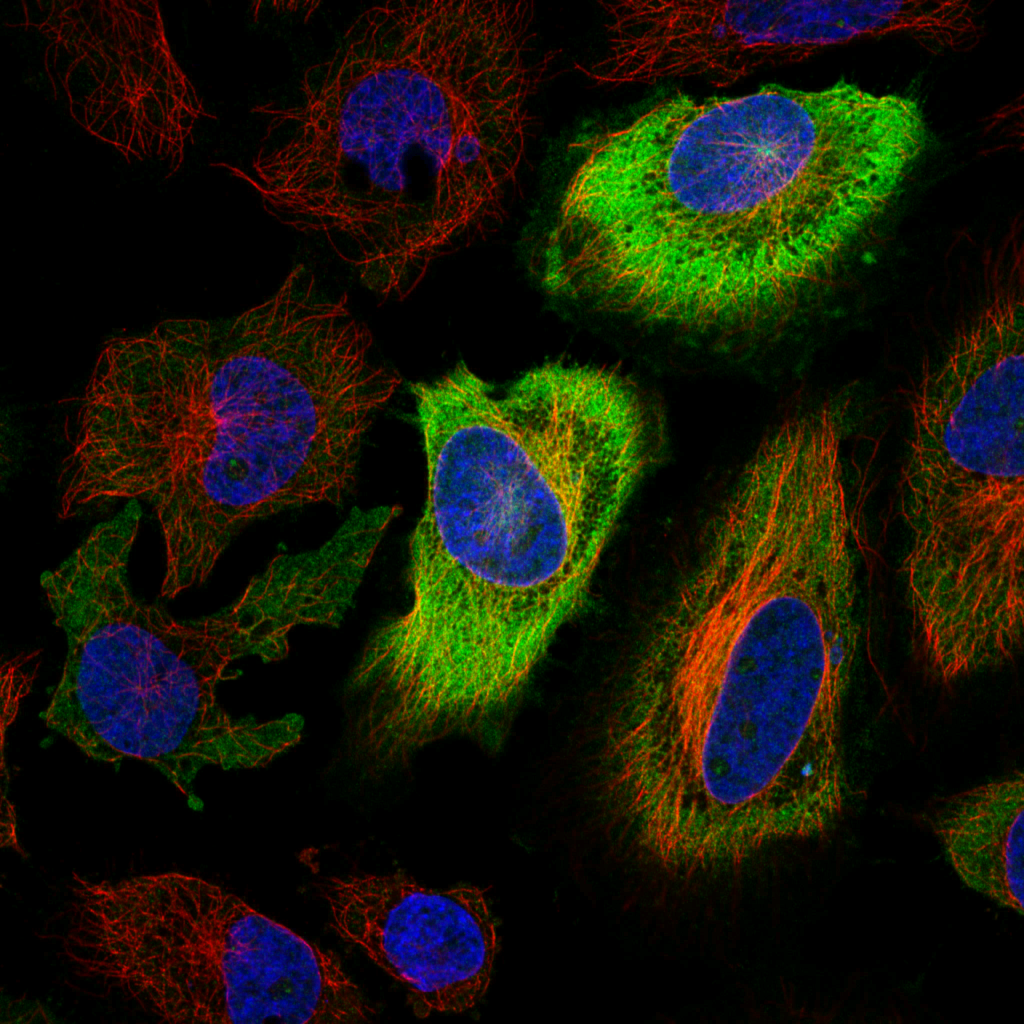

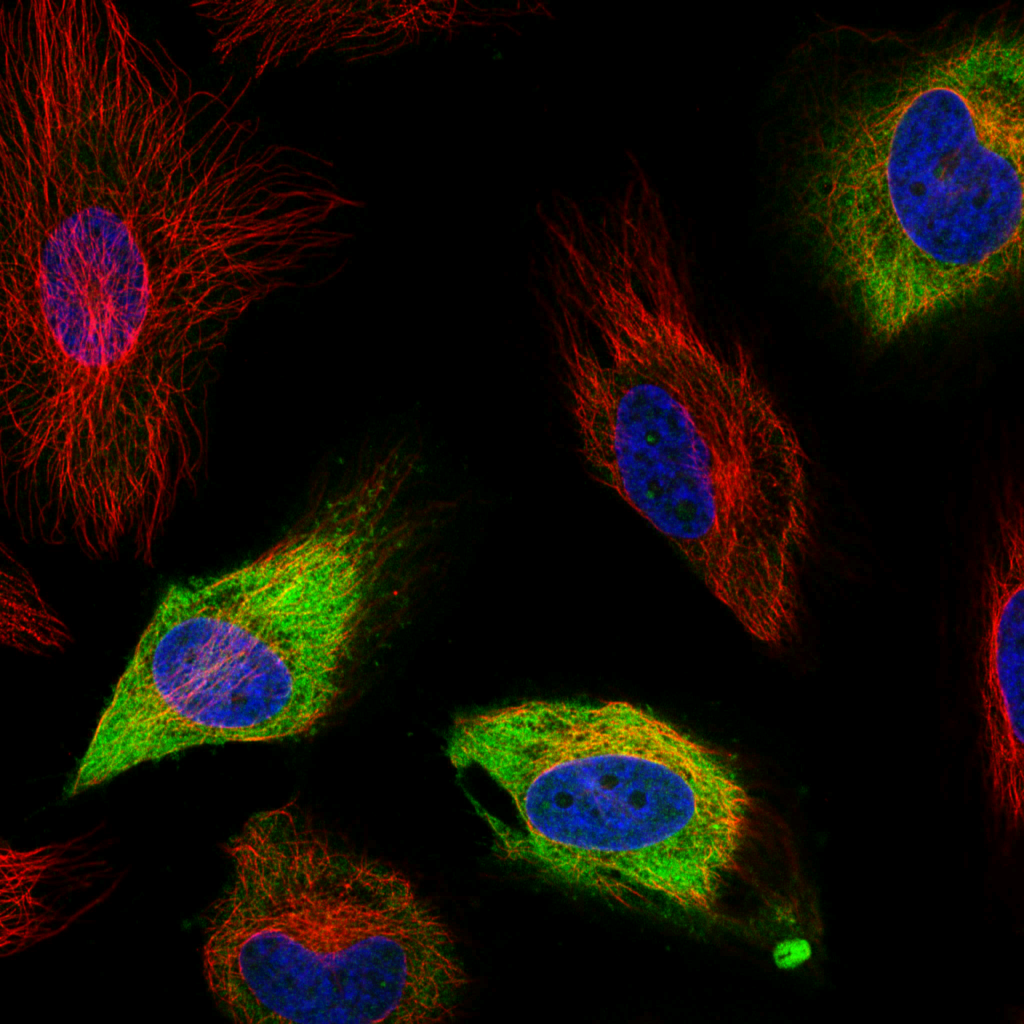

In [8]:
for image in minibatch['image']:
    display(torch_to_PIL_single_image(image))

In [9]:
minibatch_non_image = {k:v for k,v in minibatch.items() if k != 'image'}
print(json.dumps(minibatch_non_image, indent = 2))

{
  "EnsemblID": [
    "ENSG00000134057",
    "ENSG00000204209",
    "ENSG00000134057",
    "ENSG00000134057"
  ],
  "proteinID": [
    "P14635",
    "Q9UER7",
    "P14635",
    "P14635"
  ],
  "antibodyName": [
    "HPA030741",
    "HPA008797",
    "HPA061448",
    "HPA061448"
  ],
  "antigenSequence": [
    "PVPVSEPVPEPEPEPEPEPVKEEKLSPEPILVDTASPSPMETSGCAPAEEDLCQAFSDVILAVNDVDAEDGAD",
    "DEEEEAAAGKDGDKSPMSSLQISNEKNLEPGKQISRSSGEQQNKGRIVSPSLLSEEPLAPSSIDAESNGEQPEELTLEEESPVSQLFELEIEALPLDTPSSVETDISSSRKQSEEPFTTVLENGAGMVSSTSFNGGVSPHNWGDSG",
    "TRNSKINAENKAKINMAGAKRVPTAPAATSKPGLRPRTALGDIGNKVSEQLQAKMPMKKEAKPSATGKVIDK",
    "TRNSKINAENKAKINMAGAKRVPTAPAATSKPGLRPRTALGDIGNKVSEQLQAKMPMKKEAKPSATGKVIDK"
  ]
}


In [10]:
dset.opts

{'image_cols': ('microtubuleChannel', 'antibodyChannel', 'nuclearChannel'),
 'image_transform': Compose(
     Resize(size=1024, interpolation=PIL.Image.BILINEAR)
     ToTensor()
     Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
 ),
 'metadata_cols': ('EnsemblID',
  'proteinID',
  'antibodyName',
  'antigenSequence'),
 'root_dir': 'test_images'}

In [11]:
dset.df.sample(5)

EnsemblID proteinID antibodyName  \
19  ENSG00000204209    Q9UER7    HPA065779   
8   ENSG00000204209    Q9UER7    HPA008797   
67  ENSG00000126602    Q12931    HPA044227   
7   ENSG00000204209    Q9UER7    HPA008797   
63  ENSG00000126602    Q12931    HPA044227   

                                      antigenSequence cellLine  \
19  ARGSSSSGGKKCYKLENEKLFEEFLELCKMQTADHPEVVPFLYNRQ...     HeLa   
8   DEEEEAAAGKDGDKSPMSSLQISNEKNLEPGKQISRSSGEQQNKGR...     HeLa   
67  RTTAQLGPRRNPAWSLQAGRLFSTQTAEDKEEPLHSIISSTESVQG...   U-2 OS   
7   DEEEEAAAGKDGDKSPMSSLQISNEKNLEPGKQISRSSGEQQNKGR...     HeLa   
63  RTTAQLGPRRNPAWSLQAGRLFSTQTAEDKEEPLHSIISSTESVQG...   U-2 OS   

                antibodyChannel         microtubuleChannel  \
19    65779/fp11_C5_6_green.jpg    65779/fp11_C5_6_red.jpg   
8      8797/fp11_B5_2_green.jpg     8797/fp11_B5_2_red.jpg   
67  44227/si31_G10_13_green.jpg  44227/si31_G10_13_red.jpg   
7      8797/fp11_E5_2_green.jpg     8797/fp11_E5_2_red.jpg   
63     44227/713_G1_3_green.jpg     44227/713_G1_3_red.jpg   

                nuclearChannel                 segmentationChannel  
19    65779/fp11_C5_6_blue.jpg    65779/fp11_C5_6_segmentation.png  
8      8797/fp11_B5_2_blue.jpg     8797/fp11_B5_2_segmentation.png  
67  44227/si31_G10_13_blue.jpg  44227/si31_G10_13_segmentation.png  
7      8797/fp11_E5_2_blue.jpg     8797/fp11_E5_2_segmentation.png  
63     44227/713_G1_3_blue.jpg     44227/713_G1_3_segmentation.png